In [1]:
# Importing dependencies
import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
import data_prep_helper
plt.style.use('ggplot')

Using TensorFlow backend.


### Data Preprocessing

In [2]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [143]:
# Loading the dataset
do = data_prep_helper.ShiftChartData(chart_col=["Price", "High", "Low"])

In [144]:
df = do.chart_df

In [145]:
df.columns

Index(['bitcoin_Price', 'bitcoin_High', 'bitcoin_Low', 'sp500_Price',
       'sp500_High', 'sp500_Low', 'dax_Price', 'dax_High', 'dax_Low',
       'googl_Price', 'googl_High', 'googl_Low', 'gold_Price', 'gold_High',
       'gold_Low', 'alibaba_Price', 'alibaba_High', 'alibaba_Low',
       'amazon_Price', 'amazon_High', 'amazon_Low', 'bitcoin_Google_Trends',
       'cryptocurrency_Google_Trends', 'trading_Google_Trends',
       'bitcoin_pos_sents', 'bitcoin_neg_sents', 'bitcoin_quot_sents',
       'economy_pos_sents', 'economy_neg_sents', 'economy_quot_sents'],
      dtype='object')

In [6]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [7]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse,rmse, r2, Y_test, Y_hat
  

In [93]:
# Plotting the predictions
def plot_data(Y_test,Y_hat, ax="", title=""):
    if ax:
        plot = ax
    else:
        fig, ax = plt.subplots(1, 1)
        plot = ax

    plot.plot(Y_test,c = 'r')
    plot.plot(Y_hat,c = 'y')
    plot.set_xlabel('Day')
    plot.set_ylabel('Price')
    if not title:
        plot.set_title("Stock Price Prediction using Multivariate-GRU")
    else:
        plot.set_title(title)
    plot.legend(['Actual','Predicted'],loc = 'lower right')
    #plot.show()

In [94]:
# Plotting the training errors
def plot_error(train_loss,val_loss, ax="", title=""):
    if ax:
        plot = ax
    else:
        fig, ax = plt.subplots(1, 1)
        plot = ax
        
    plot.plot(train_loss,c = 'r')
    plot.plot(val_loss,c = 'b')
    plot.set_ylabel('Loss')
    plot.set_xlabel('Epochs')
    if not title:
        plot.set_title('Loss Plot')
    else:
        plot.set_title(title)
    plot.legend(['train','val'],loc = 'lower right')
    #plot.show()

### Model Building

In [255]:
features = [ 'bitcoin_Price_prev_month',
             'alibaba_Price_prev_month',
             #'alibaba_Low_prev_month',
             'alibaba_High_prev_month',
             #'amazon_Price_prev_month',
             #'amazon_Low_prev_month',
             'amazon_High_prev_month',
             #'googl_Price_prev_month',
             #'googl_Low_prev_month',
             #'googl_High_prev_month',
             'bitcoin_Google_Trends_prev_month',
             'economy_pos_sents_prev_month',
             'cryptocurrency_Google_Trends_prev_month',
             ]

features_test = [x.split("_prev_month")[0] for x in features]
#features_test = features

In [235]:
#creating the train and validation set
train_real = df[:1350]
train = df[:1350]
val = df[1350:1500]
test_real = df[1500:]
test = df[1500:]

In [236]:
train = do.get_causal_const_shift(train, past="all")[features]
val = do.get_causal_const_shift(val, past="all")[features]
test_bitcoin = test[["bitcoin_Price"]]

test = do.get_causal_const_shift(test, past="all")[features]

In [237]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train)

sc = MinMaxScaler()
val = sc.fit_transform(val)

sc = MinMaxScaler()
test = sc.fit_transform(test)
print(train.shape,val.shape,test.shape)

(1319, 7) (119, 7) (358, 7)


In [238]:
true_c = MinMaxScaler()
test_bitcoin = true_c.fit_transform(test_bitcoin)

In [242]:
timesteps = 5
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 200

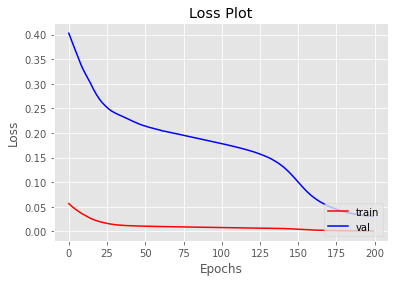

In [243]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

In [262]:
from pandas.tseries.offsets import DateOffset


In [277]:
test_int = df[1500:]

In [278]:
test_int.head()

,bitcoin_Price,bitcoin_High,bitcoin_Low,sp500_Price,sp500_High,sp500_Low,dax_Price,dax_High,dax_Low,googl_Price,...,amazon_Low,bitcoin_Google_Trends,cryptocurrency_Google_Trends,trading_Google_Trends,bitcoin_pos_sents,bitcoin_neg_sents,bitcoin_quot_sents,economy_pos_sents,economy_neg_sents,economy_quot_sents
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-16,3682.1,3734.675,3651.975,2776.64,2778.5775,2762.0025,11302.1525,11335.1475,11075.3425,1121.35,...,1603.515,1343.5,155.75,1697.0,0.143951,0.072251,1.991427,0.115480,0.065464,1.776458
2019-02-17,3759.5,3821.050,3722.550,2777.68,2781.4950,2763.7650,11304.5050,11347.2450,11131.7350,1123.07,...,1602.530,1450.0,161.50,1728.0,0.147957,0.072838,2.030066,0.119502,0.070164,1.718662
2019-02-18,3836.9,3907.425,3793.125,2778.72,2784.4125,2765.5275,11306.8575,11359.3425,11188.1275,1124.79,...,1601.545,1556.5,167.25,1759.0,0.151962,0.073425,2.068705,0.123524,0.074864,1.660865
2019-02-19,3914.3,3993.800,3863.700,2779.76,2787.3300,2767.2900,11309.2100,11371.4400,11244.5200,1126.51,...,1600.560,1663.0,173.00,1790.0,0.155968,0.074012,2.107345,0.127547,0.079564,1.603069
2019-02-20,3972.4,3983.600,3881.200,2784.70,2789.8800,2774.0600,11401.9700,11437.4700,11318.7400,1120.59,...,1610.120,1527.0,148.00,1787.0,0.161076,0.045984,3.502853,0.113327,0.057010,1.987848


In [377]:
feat_prep = [x.replace("_prev_month","{}") for x in features]


In [378]:
test_temp = df[1500:]
test_temp = test_temp[test_temp.index < "2019-10-01"]
test_temp_1 = do.get_causal_const_shift(test_temp, past="all")[features]

In [379]:
test_temp_2 = do.get_causal_const_shift(test_temp, past="all")[features_test]

In [380]:
fore_cast = test_temp_2[test_temp_2.index <= "2019-10-01"].iloc[-30:,:]
fore_cast.index = fore_cast.index + DateOffset(abs(-30))


In [381]:
future_dict = {x.format(""):x.format("_prev_month") for x in feat_prep}
fore_cast.rename(columns=future_dict, inplace=True)
    

In [382]:
        
forecast_exp = pd.concat([test_temp_1[features], fore_cast[features]])

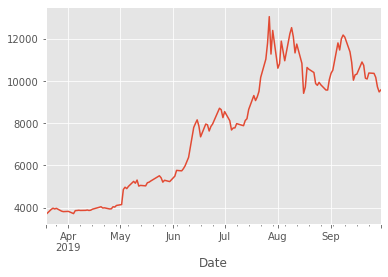

In [364]:
test_temp_1["bitcoin_Price_prev_month"].plot()

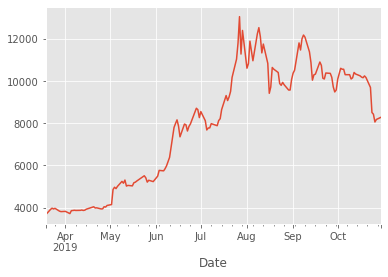

In [365]:
forecast_exp["bitcoin_Price_prev_month"].plot()

In [367]:
forecast_exp[["bitcoin_Price_prev_month"]]

,bitcoin_Price_prev_month
Date,
2019-03-19,3682.100000
2019-03-20,3759.500000
2019-03-21,3836.900000
2019-03-22,3914.300000
2019-03-23,3972.400000
...,...
2019-10-26,8063.800000
2019-10-27,8184.900000
2019-10-28,8218.033333


In [383]:

price_c = MinMaxScaler()
price_scaled = price_c.fit_transform(forecast_exp[["bitcoin_Price_prev_month"]])

In [384]:
sc = MinMaxScaler()
forecast_exp = sc.fit_transform(forecast_exp)


MSE = 0.03207105580418022
RMSE = 0.17908393508123563
R2-Score = 0.6322553496737665


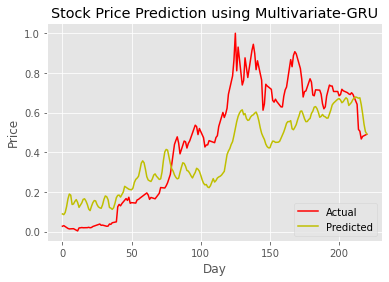

In [385]:
mse,rmse,r2_value,true,predicted = evaluate_model(model, forecast_exp, 5)
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)

In [386]:
price_c.inverse_transform(predicted)

array([[ 4519.8965],
       [ 4486.1504],
       [ 4588.26  ],
       [ 4858.9185],
       [ 5229.1816],
       [ 5459.537 ],
       [ 5406.049 ],
       [ 4965.9937],
       [ 4988.9443],
       [ 5111.668 ],
       [ 5196.494 ],
       [ 5061.3516],
       [ 4830.8394],
       [ 4931.129 ],
       [ 5039.986 ],
       [ 5209.3745],
       [ 5235.0625],
       [ 5128.3804],
       [ 4969.01  ],
       [ 4752.8457],
       [ 4675.0024],
       [ 4878.973 ],
       [ 5051.314 ],
       [ 5150.3735],
       [ 5135.1084],
       [ 4964.675 ],
       [ 4852.937 ],
       [ 4809.1143],
       [ 4784.289 ],
       [ 4944.9424],
       [ 5203.3594],
       [ 5368.585 ],
       [ 5333.8555],
       [ 5195.201 ],
       [ 4825.013 ],
       [ 4796.2656],
       [ 4735.1113],
       [ 4810.3037],
       [ 5023.117 ],
       [ 5289.5186],
       [ 5397.9604],
       [ 5409.354 ],
       [ 5316.241 ],
       [ 5434.8037],
       [ 5556.505 ],
       [ 5824.493 ],
       [ 5780.616 ],
       [ 5732

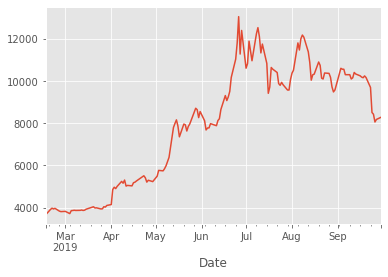

In [336]:
test_int[test_int.index < "2019-10-01"]["bitcoin_Price"].plot()

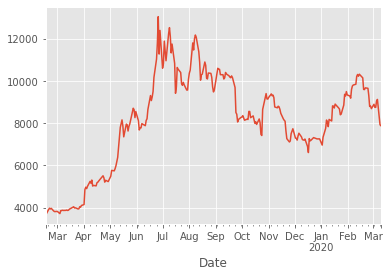

In [213]:
test_real["bitcoin_Price"].plot()

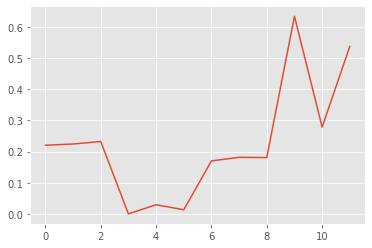

In [187]:
plt.plot(test[0])

In [185]:
np.shape(true)

(329,)

In [184]:
np.shape(predicted)

(329, 1)

In [183]:
np.shape(test)

(389, 12)

In [ ]:
predicted.reshape(len(predicted))

In [ ]:
true_c.inverse_transform(true.reshape(-1,1))

In [114]:
pd.DataFrame(true, index=test.index[:len(true)])

,0
Date,
2019-02-16,0.243375
2019-02-17,0.259081
2019-02-18,0.292779
2019-02-19,0.324289
2019-02-20,0.360759
...,...
2019-05-20,0.889132
2019-05-21,0.850328
2019-05-22,0.860248


In [337]:
# Save a model
model.save('models/gru_12_feat_month.h5')

## Cross Validation

In [387]:
timesteps = 5
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 200

In [388]:
do = data_prep_helper.ModelData(chart_col=["Price", "High", "Low"])

In [389]:
def gen_scaled_train_val_test(df, split=""):
    if split:
        split_range = range(0,split)
    else:
        split_range = range(2,3)
    for split_number in split_range:
        train = df[:900+(split_number*300)]
        val = df[900+(split_number*300):1100+(split_number*300)]
        test = df[1100+(split_number*300):]    

        train = do.get_causal_const_shift(train, past="all")[features]
        val = do.get_causal_const_shift(val, past="all")[features]
        test = do.get_causal_const_shift(test, past="all")[features]

        sc = MinMaxScaler()
        train = sc.fit_transform(train)
        sc = MinMaxScaler()
        val = sc.fit_transform(val)
        sc = MinMaxScaler()
        test = sc.fit_transform(test)
        
        yield train, val, test, split_number

Epoch 00092: early stopping
S_0_MSE: 0.056550575222985545
S_0_RMSE: 0.2378036484644118
S_0_R2: -0.23226556658580688
S_1_MSE: 0.009690142995983496
S_1_RMSE: 0.09843852394252718
S_1_R2: 0.867726462440249
S_2_MSE: 0.08156038601678985
S_2_RMSE: 0.28558779038465537
S_2_R2: -0.41910356938131343


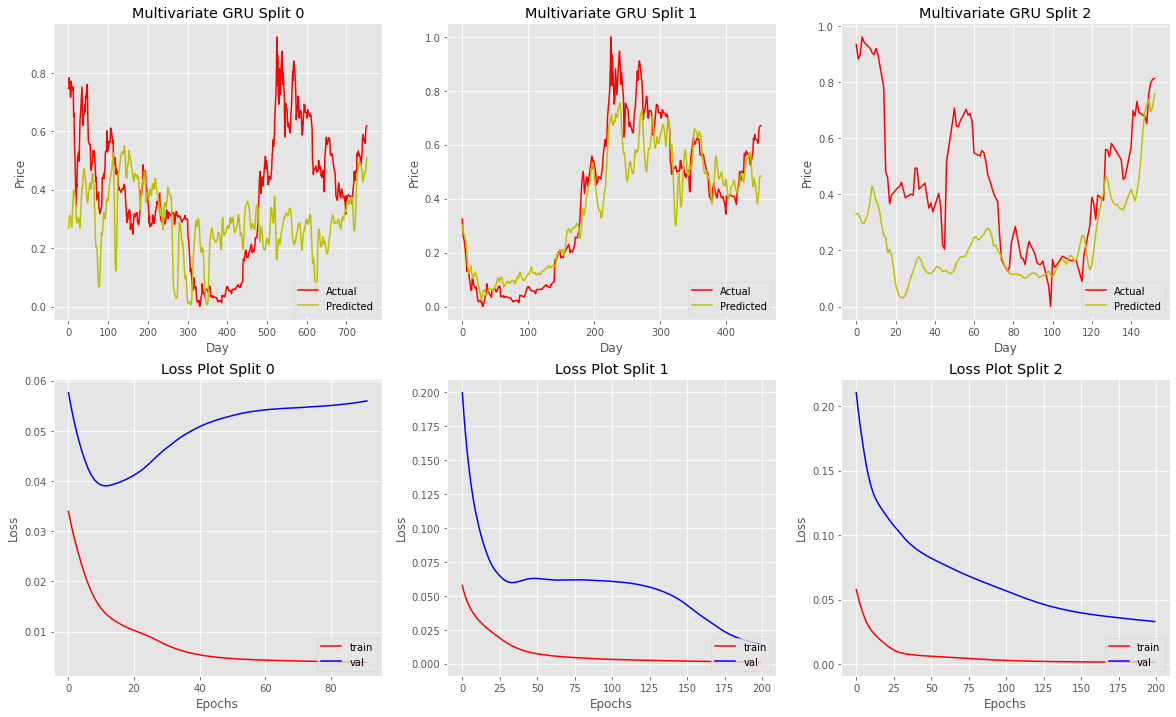

In [390]:
result_dict={}
fig, ax = plt.subplots(2, 3, figsize=(20,12))

for train,val,test,split_index in gen_scaled_train_val_test(do.chart_df,split=3):
    
    cross_val_results = list()
    train_loss = pd.DataFrame()
    val_loss = pd.DataFrame()
    model,train_error,val_error = fit_model(train, val,timesteps,hl,lr,batch_size,num_epochs)
    model.save('models/gru_12_feat_month_S{}.h5'.format(split_index))

    
    mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
    result_dict["S_{}_MSE".format(split_index)] = mse
    result_dict["S_{}_RMSE".format(split_index)] = rmse
    result_dict["S_{}_R2".format(split_index)] = r2_value

    plot_data(true, predicted, ax[0][split_index], "Multivariate GRU Split {}".format(split_index))
    plot_error(train_error, val_error, ax[1][split_index], "Loss Plot Split {}".format(split_index))
    
for key, val in result_dict.items():
    print("{}: {}".format(key, val))